<a href="https://colab.research.google.com/github/chatterjeerajdeep/machine-learning-projects/blob/main/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# !pip install pycaret
# !pip install markupsafe==2.0.1

In [58]:
# !pip install association-metrics

An interactive business presentation of the business understanding, exploratory analysis, actionable insights and predictive modeling for this project is here: http://app-live-demo.herokuapp.com/

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from pycaret.classification import *
from sklearn.metrics import fbeta_score, make_scorer

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Companies like Netflix, Spotify, etc. and Internet/Telecom Service Providers have a subscription-based business model. They rely on their customer base for business.

When a customer moves away from their existing subscription to a competitor, it is a major disadvantage. This is called Customer Churn. Customer Churn creates a huge impact on the business and the business tries its best to prevent or minimize churn.

A telecommunications company (hereby “TelCo”), who sells residential Voice and Internet services, is experiencing a massive customer churn rate of nearly 27%.


In [3]:
# Data exploration
data = pd.read_csv(r"/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(data.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


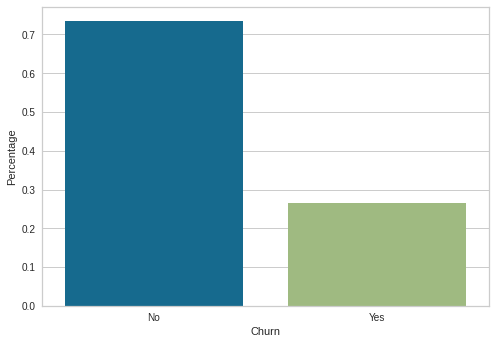

In [4]:
d = data.Churn.value_counts(normalize=True).reset_index(name="Percentage")
d.rename(columns={"index": "Churn"}, inplace=True)
ax = sns.barplot(data = d, x="Churn", y="Percentage")


In [5]:
data = data[~data["TotalCharges"].eq(" ")]
data["TotalCharges"] = data["TotalCharges"].apply(lambda x: np.float64(x))

Univariate Analysis

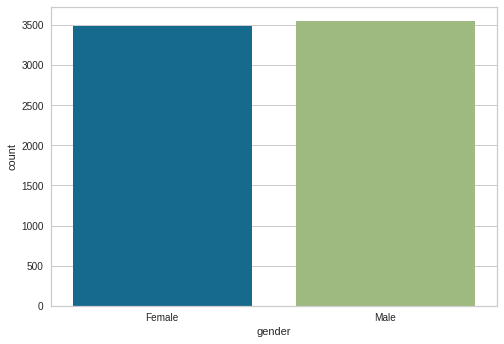

In [6]:
# Which gender has more subscribers?
sns.countplot(data = data, x="gender")
# there are fairly equal numbers of male and female subscribers

In [7]:
# what % of subscribers are senior citizens?
data["SeniorCitizen"].value_counts(normalize=True)
# About 16% of the subscribers are senior citizens

0    0.8376
1    0.1624
Name: SeniorCitizen, dtype: float64

In [8]:
# What % of subscribers have partners and dependents?
print(data["Partner"].value_counts(normalize=True))
print(data["Dependents"].value_counts(normalize=True))
# 48% of subscribers have partners and 30% have dependents

No     0.517491
Yes    0.482509
Name: Partner, dtype: float64
No     0.701507
Yes    0.298493
Name: Dependents, dtype: float64


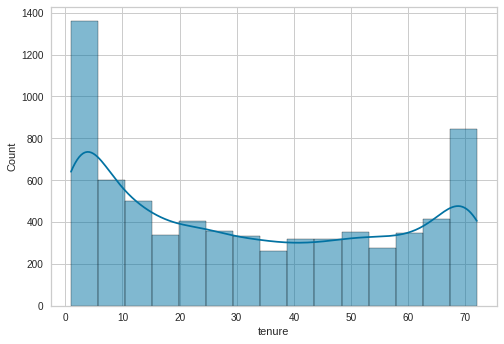

In [9]:
# what is the distribution of tenure of the subscribers
sns.histplot(data=data, x='tenure', kde=True)

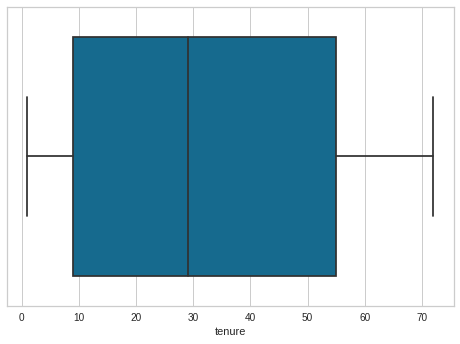

In [10]:
sns.boxplot(data=data, x="tenure")
# there are no outliers, but people tend to leave more within the first 2-2.5 years

In [11]:
# what % of subscribers use Internet Service
data["InternetService"].value_counts(normalize=True)
# About 22% of subscribers do not have an Internet Service. This can be important
# If a subscriber does not use Internet Service, but has a high chance of churning
# then offering the subscriber data benefits would be of no use
# so it is worth exploring how the churn varies with internet usage

Fiber optic    0.440273
DSL            0.343572
No             0.216155
Name: InternetService, dtype: float64

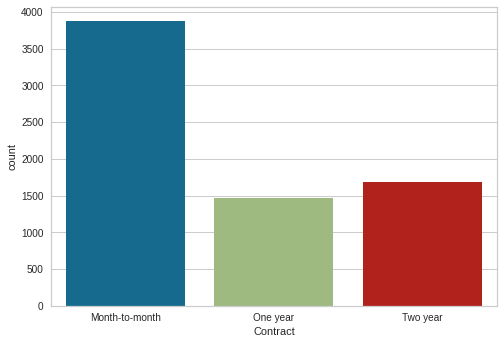

In [12]:
# what is the distribution of the contract term 
sns.countplot(data=data, x='Contract')
# Most subscribers use a month-to-month contract
# I will not be surprised, if people with One year or two year contracts tend to churn less

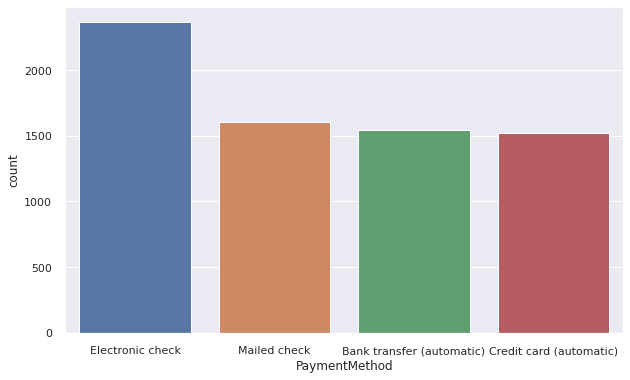

In [13]:
# what is the payment method used by most customers
sns.set(rc = {'figure.figsize':(10,6)})
sns.countplot(data=data, x='PaymentMethod')

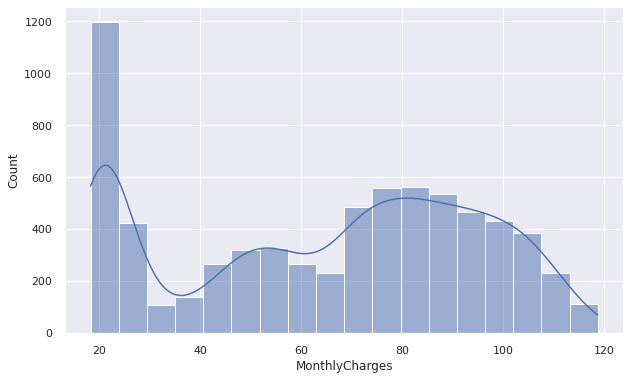

In [14]:
# what is the distribution of  monthly charges 
sns.histplot(data=data, x="MonthlyCharges", kde=True)
# maximum number of users use low-cost offers

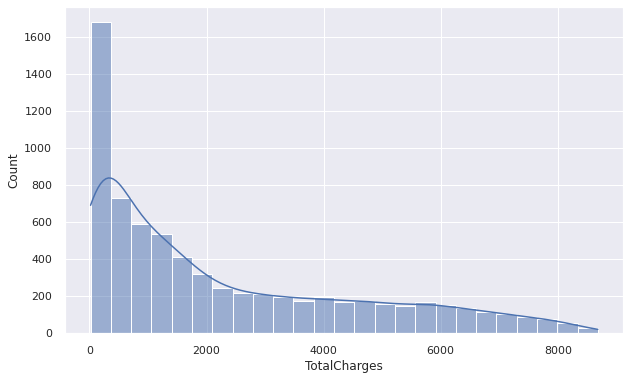

In [15]:
# what is the distribution of total charges
sns.histplot(data=data, x="TotalCharges", kde=True)


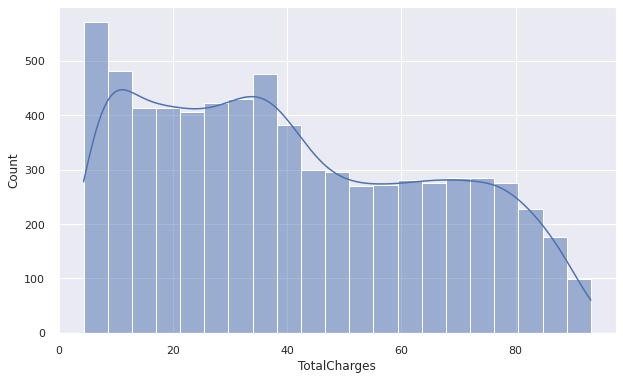

In [16]:
sns.histplot(data=data, x=data["TotalCharges"].apply(lambda x: np.sqrt(x)), kde=True)


Bivariate Analysis

In [17]:
# first let's convert SeniorCitizen into a categorical column
data["SeniorCitizen"] = data["SeniorCitizen"].apply(lambda x: "Yes" if x == 1 else "No")

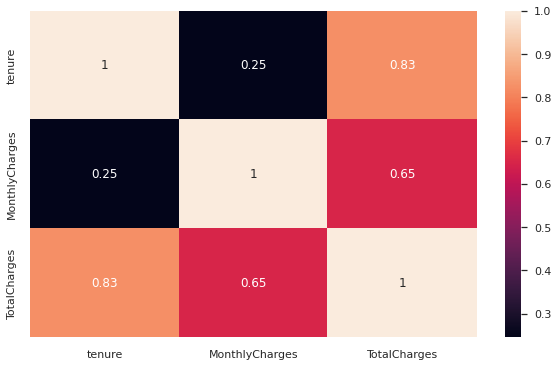

In [18]:
# first, we can check for correlation between numeric features
corr_data = data.corr(method='pearson')
sns.heatmap(corr_data, annot=True)
# total charges keep increasing with tenure, so it will be wise to keep either one
# monthly charges and total charges have correlation greater than 0.5 but not too high
# since pearson's correlation can capture linear relationship 
# we can verify if there's a linear relationship between tenure, monthly charges and total charge

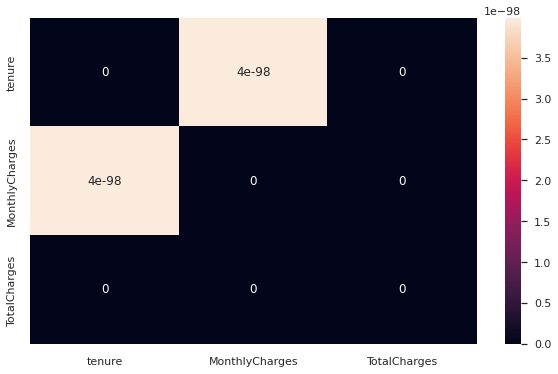

In [19]:
# do we have enough data to trust the correlation?
# is the correlation statistically significant?
# the questions are the same and can be answered by the p-value

from scipy.stats import kendalltau, pearsonr, spearmanr

corr = data.corr(method=lambda x, y: pearsonr(x, y)[1])
corr = corr - np.eye(len(corr.columns)) 
sns.heatmap(corr, annot=True)


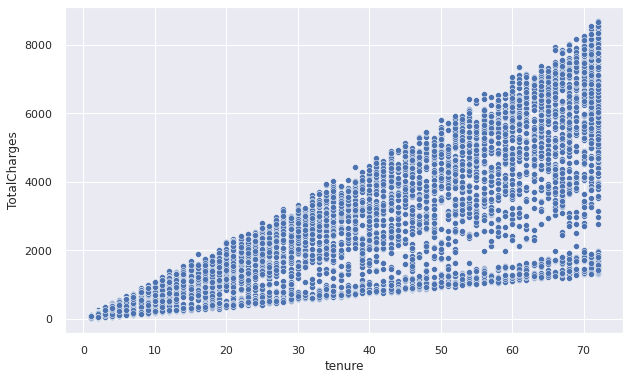

In [20]:
sns.scatterplot(x="tenure", y="TotalCharges", data=data)
# yes, there's a visible linear relation between tenure and total charges

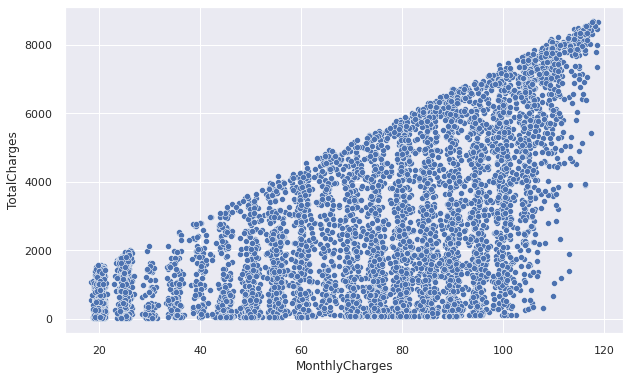

In [21]:
sns.scatterplot(x="MonthlyCharges", y="TotalCharges", data=data)
# there's also a linear relation between monthly and total charges

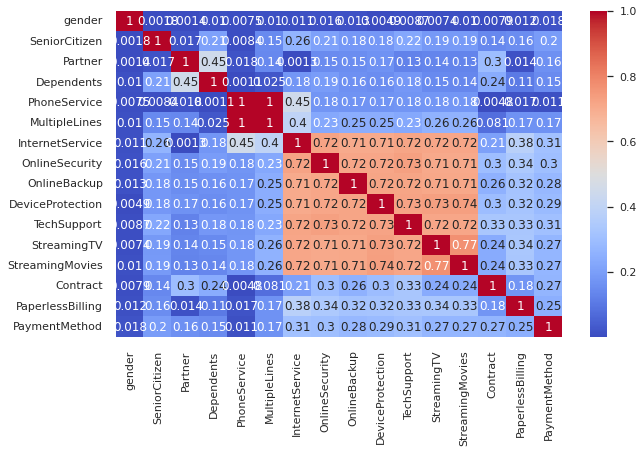

In [22]:
from pandas.core.frame import DataFrame
# we can also explore correlation between categorical variables
# we need to use Cramer's V to identify such correlation

import association_metrics as am

# we have to convert the type of the categorical features to category
df = data.copy()
df.drop(["Churn", "customerID"], axis=1, inplace=True)
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
cramersv = am.CramersV(df) 
sns.heatmap(cramersv.fit(), cmap="coolwarm", annot=True)

# some interesting observations:
# 1. all the internet based services are correlated with one another
# 2. Multiple Lines have a high correlation with Phone Service, which is very obvious
# 3. Partner and Dependents have a correlation of about 0.5
# 4. Paperless billing have a somewhat 0.5 correlation with Internet Service which is really logical
# 4. the remaining categorical features are pretty low on the correlation score

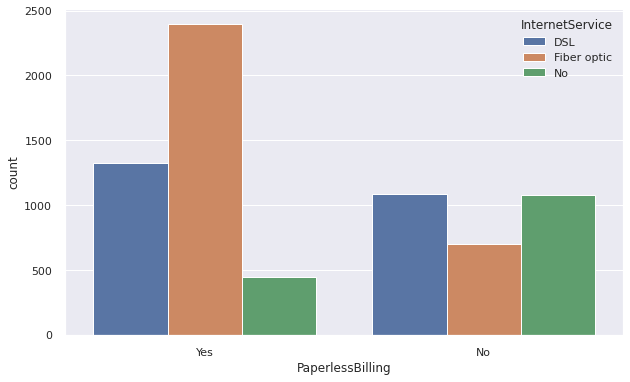

In [23]:
# I would like to explore more on the relation between paperless billing and Internet Service
sns.countplot(data=data, x="PaperlessBilling", hue="InternetService")
# subs using DSL and fiber Optic clearly opt more for paperless billing

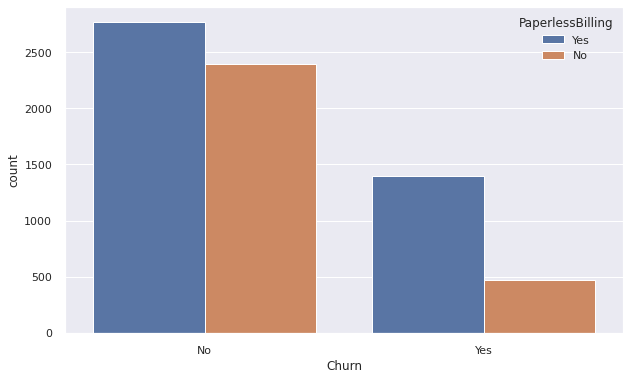

In [24]:
# does paperless billing have anything to do with churn?
sns.countplot(data=data, x="Churn", hue="PaperlessBilling")
# subs who have opted for paperless billing have churned more

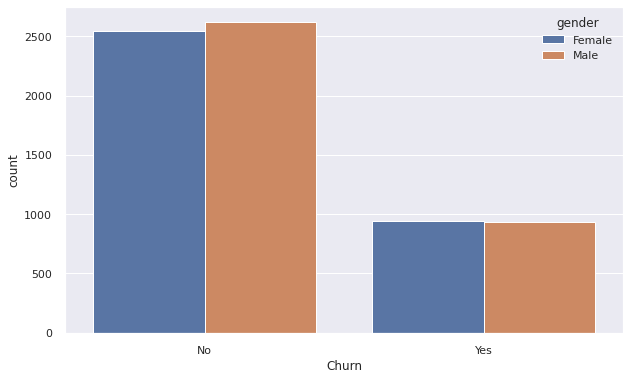

In [25]:
# is there any difference in the churn w.r.t gender ?
sns.countplot(data=data, x="Churn", hue="gender")
# male and female have similar counts of churn

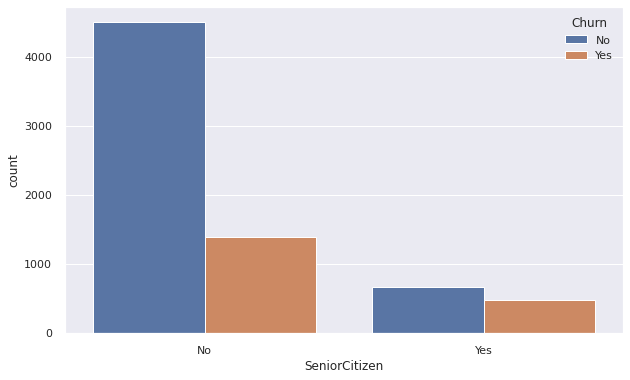

In [26]:
# have senior citizens churned more?
sns.countplot(data=data, x="SeniorCitizen", hue="Churn")
# there are more number of Senior Citizens who do not churn, as compared to those who churn

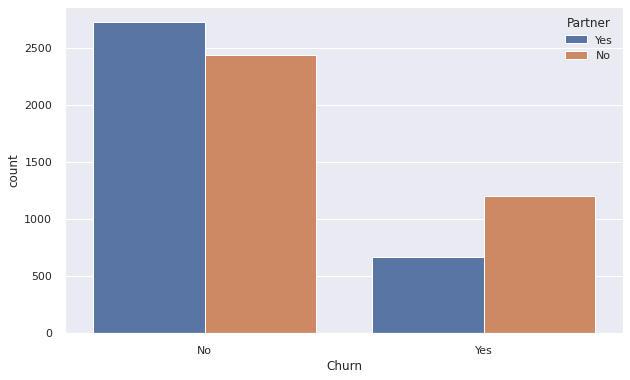

In [27]:
# does having partner or dependents have had anything to do with Churning?
sns.countplot(data=data, x="Churn", hue="Partner")
# people without partners have churned more
# we have to keep in mind, that the count of subscribers without partners is also slightly greater

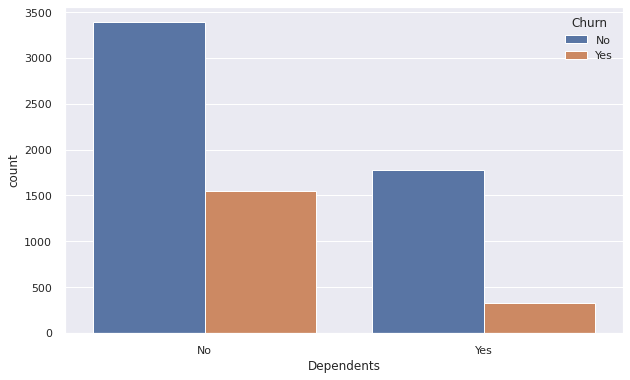

In [28]:
sns.countplot(data=data, x="Dependents", hue="Churn")
# subscribers with dependents have a lower count of churning
# we also have to keep in mind, that there is much lesser number of subs with dependents

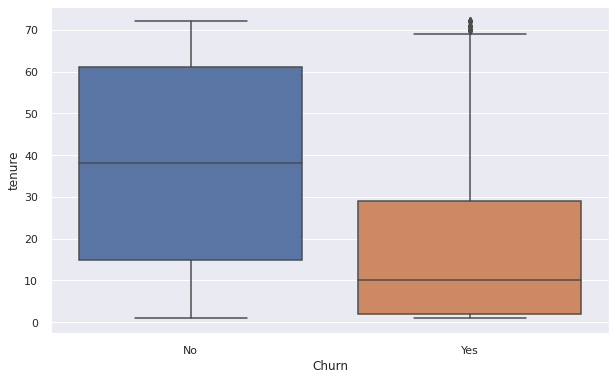

In [29]:
# how different is the distribution of tenure for those who churned?
sns.boxplot(data=data, x="Churn", y="tenure")
# this is quite expected, those who churned mostly had a lower tenure
# interestingly there are some outliers

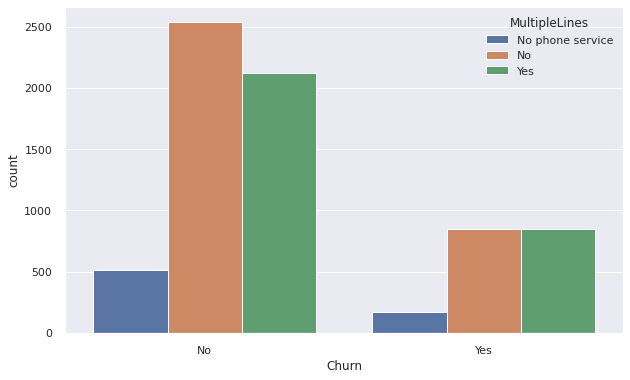

In [30]:
# have subs with multiple lines churned more?
sns.countplot(data = data, x ='Churn', hue="MultipleLines")
# not really

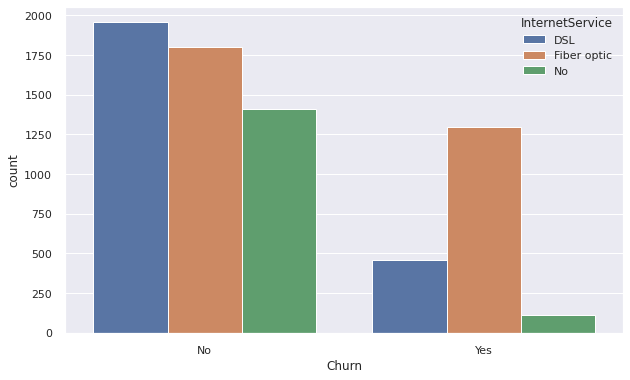

In [31]:
# have subs with internet service churned more?
sns.countplot(data = data, x ='Churn', hue="InternetService")
# subs with Fiber optic internet service have churned more

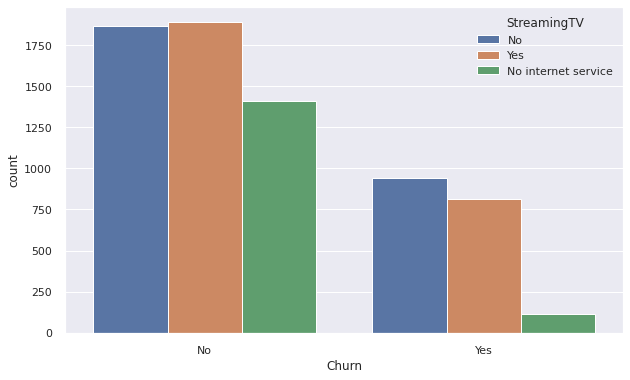

In [32]:
# have subs with streaming TV or streaming movies, churned more?
sns.countplot(data=data, x="Churn", hue="StreamingTV")
# subs who do not stream TV have churned more

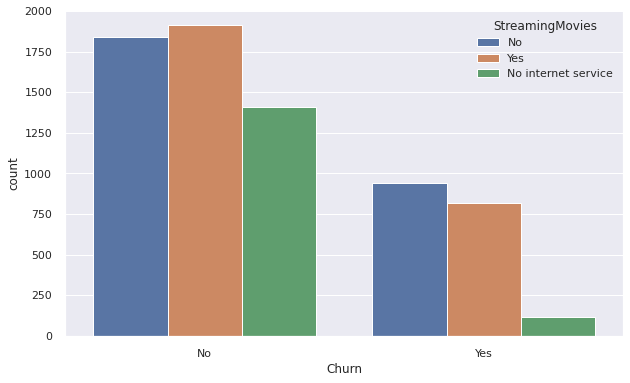

In [33]:
sns.countplot(data=data, x="Churn", hue="StreamingMovies")
# subs who do not stream Movie have churned more

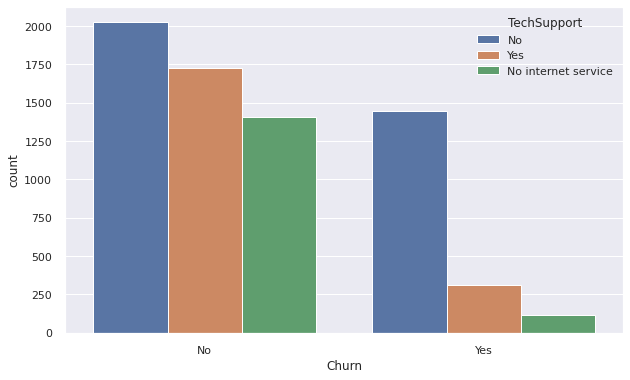

In [34]:
# what about tech support?
sns.countplot(data=data, x="Churn", hue="TechSupport")
# subs with No Tech Support have churned much more

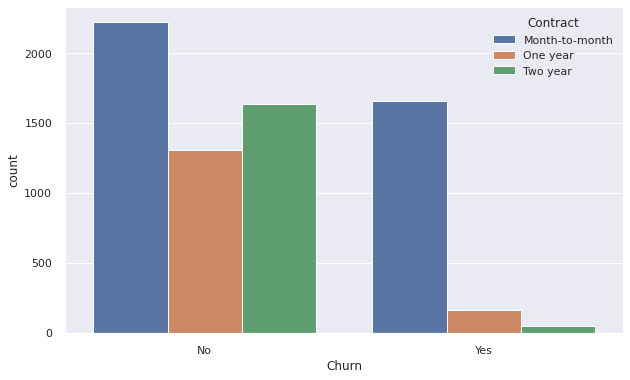

In [35]:
# subs with what kind of contracts have churned more?
sns.countplot(data = data, x ='Churn', hue="Contract")
# the count of month-to-month subs are much more and they have churned a lot

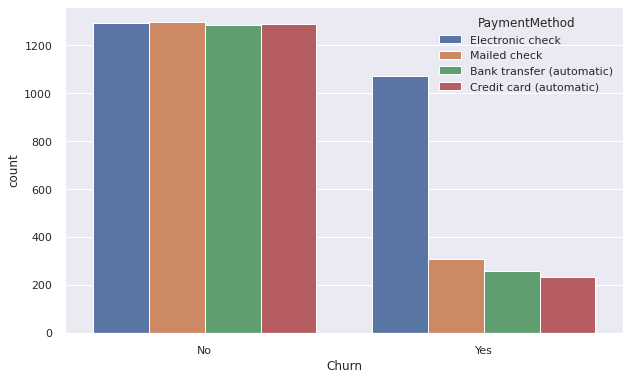

In [36]:
# subs with which kind of payment method have churned more?
sns.countplot(data = data, x ='Churn', hue="PaymentMethod")
# subs with automatic payments methods have churned much less
# probably because the process is seamless
# but subs with electrinic check has churned the most
# maybe there is an hassle or more chances of failure in this process

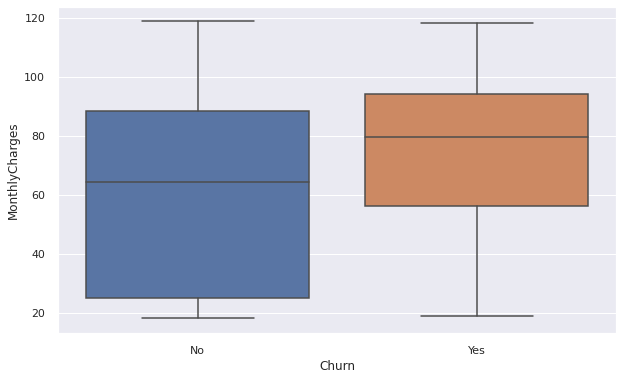

In [37]:
# is there a change in the distribution of monthly charges for those who have churned?
sns.boxplot(data=data, x="Churn", y="MonthlyCharges")

# those who churned, had a higher montly charge than those who didn't

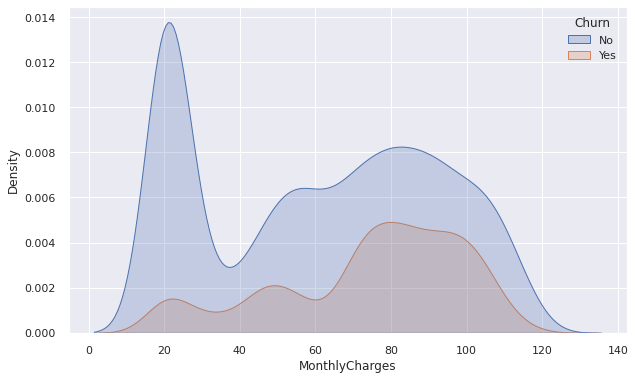

In [38]:
sns.kdeplot(data=data, x="MonthlyCharges", hue="Churn", fill=True)

### Summing up the conclusions till now:
1. There's almost an equal numbers of male and female subscribers
2. About 16% of subs are senior citizens and their odds of churning have been lower
3. Most subs prefer to have a lower monthly charge. However, those who churned had a comparatively higher monthly charge
4. Subs who have a month-to-month contract have churned much more than subs availing other forms of contract
5. Subs with electronic check mode of payment have churned much more than other modes of payment
6. Subs with no tech support have churned much more than the ones with tech support
7. Subs with Fibre Optic as their internet service have churned much more than DSL and no internet service
8. Subs with internet service prefer to use paperless billing
8. Subs who have churned mostly have lower tenures, but there are some subs with very high tenures (outliers), who have churned

## Possible Issues
1. Charging higher to subs with lower tenures
2. Contract policies other than month-to-month are not very useful to the subscriber
3. Some issue exists in the electronic check mode of payment
4. The issue is probably with tech support
5. Internet users are availing paperless billing options. If there's an issue in the paperless biling system it is driving subs away



### Interesting questions
1. What is the mode of payment of subs who are paying a higher monthly charge?
2. Is Fibre optic costly?
3. Subs with a high tenure, are generally loyal subs. Why are they churning?


In [39]:
# multivariate analysis

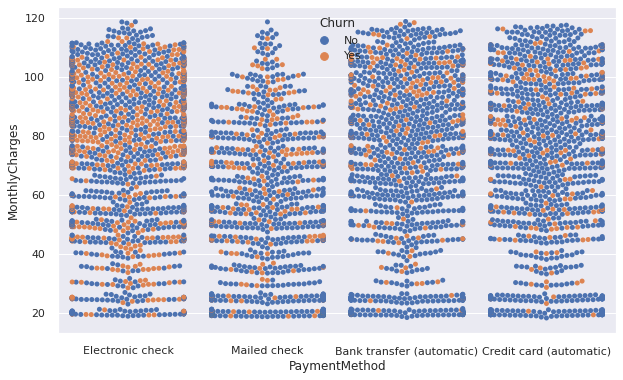

In [40]:
sns.swarmplot(data=data, x="PaymentMethod", y="MonthlyCharges", hue="Churn")
# subs with a higher monthly charge have mostly availed the electronic check mode of payment
# along with the automatic modes. The mailed check mode is used comparatively lesser. 

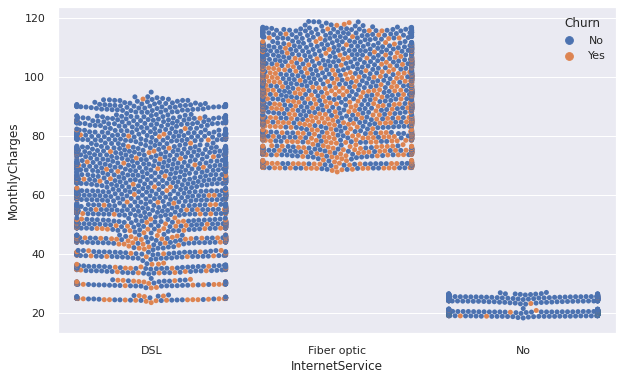

In [41]:
sns.swarmplot(data=data, x="InternetService", y="MonthlyCharges", hue="Churn")
# yes, fiber optic is the costliest

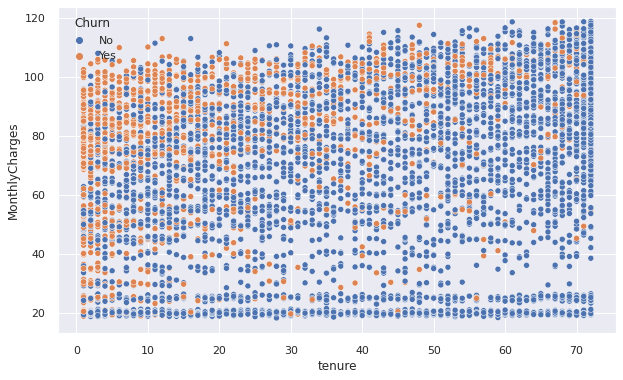

In [42]:
sns.scatterplot(data=data, y="MonthlyCharges", x="tenure", hue="Churn")
# the few subs who have churned even after having a very high tenure
# have done so probably because of high monthly charges
# but clearly some subs with lower monthly charges and high tenure have also churned


In [43]:
# Before we go for finding the feature importances, we can take a look at how the categorical variables
# correlate to the target
# I am using the Cramer's V once again to find this
import association_metrics as am
df = data.copy()
# customer ID is of no use
df.drop(["customerID"], axis=1, inplace=True)
# the package requires the column types to be category
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
cramersv = am.CramersV(df) 
cramersv = cramersv.fit()


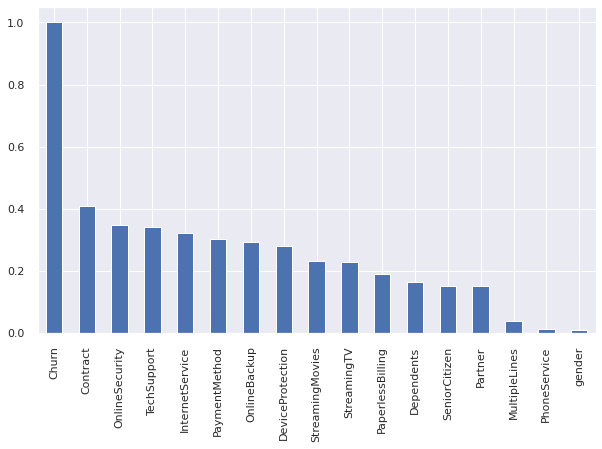

In [44]:
cramersv["Churn"].sort_values(ascending=False).plot(kind='bar')
# this gives us an idea of the relative importances of the features

In [45]:
# Data preparation

In [46]:
# Do we have missing values?
data.isnull().sum()
# no

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [47]:
# convert the categorical features into numerical
processed_data = pd.get_dummies(data=data, columns=["gender", "SeniorCitizen", "MultipleLines", "InternetService", "Contract", "PaymentMethod", "Partner", "Dependents", "PhoneService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "PaperlessBilling", "Churn"], drop_first=True)
processed_data.rename(columns={"Churn_Yes": "Churn"}, inplace=True)
processed_data.drop("customerID", axis=1, inplace=True)


In [48]:
# split the data into features and target

y = processed_data["Churn"]
x = processed_data.drop("Churn", axis=1)

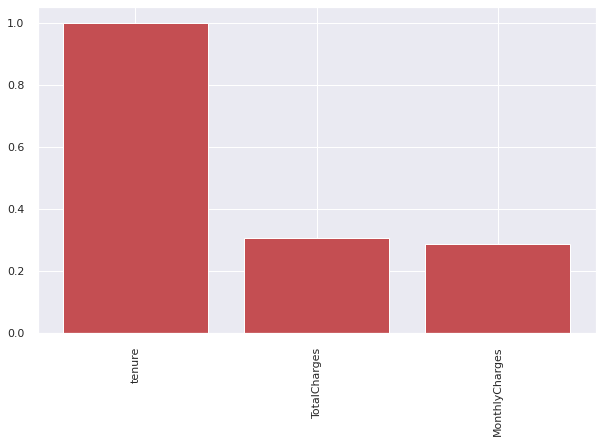

In [49]:
# feature selection
# try annova for numeric features

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k="all")
X = x[["tenure", "MonthlyCharges", "TotalCharges"]]
selector.fit(X, y)

scores = -np.log10(selector.pvalues_)
scores /= scores.max()

indices = np.argsort(scores)[::-1]

# To get your top 10 feature names
features = []
for i in range(len(X.columns)):
    features.append(X.columns[indices[i]])

# Now plot
plt.figure()
plt.bar(features, scores[indices[range(len(X.columns))]], color='r', align='center')
plt.xticks(rotation = 90)
plt.show()

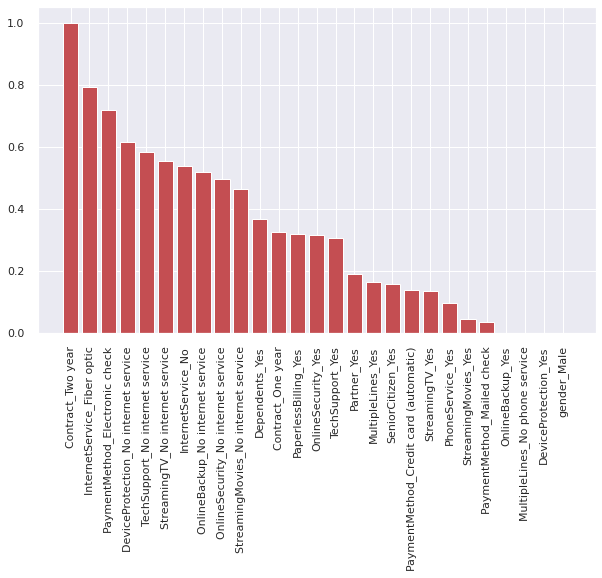

In [50]:
# feature selection
# try mutual info for categorical features

from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k='all')
X = x.drop(["tenure", "MonthlyCharges", "TotalCharges"], axis=1)
selector.fit(X, y)

scores = selector.scores_
scores /= scores.max()

indices = np.argsort(scores)[::-1]

# To get your top 10 feature names
features = []
for i in range(len(X.columns)):
    features.append(X.columns[indices[i]])

# Now plot
plt.figure()
plt.bar(features, scores[indices[range(len(X.columns))]], color='r', align='center')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
# feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

model = SelectKBest(mutual_info_classif, k=10)
model.fit(X,y)
mask = model.get_support()
new_features = X.columns[mask]
print(new_features)

Index(['InternetService_Fiber optic', 'InternetService_No',
       'Contract_Two year', 'PaymentMethod_Electronic check',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service'],
      dtype='object')


predictive modeling

In [51]:
s = setup(data, target = 'Churn', ignore_features = ['customerID'], data_split_stratify=True)


,Description,Value
0,session_id,2059
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7032, 21)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
add_metric('ftwo_custom', 'Ftwo', fbeta_score, beta=2)
best_model = compare_models(sort='Ftwo')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Ftwo,TT (Sec)
nb,Naive Bayes,0.7462,0.8307,0.7698,0.5156,0.6171,0.4384,0.4586,0.7003,0.021
lda,Linear Discriminant Analysis,0.7952,0.8366,0.5550,0.6310,0.5895,0.4541,0.4564,0.5681,0.061
lr,Logistic Regression,0.8027,0.8431,0.5450,0.6558,0.5943,0.4656,0.4697,0.5635,0.706
ada,Ada Boost Classifier,0.8043,0.8483,0.5336,0.6644,0.5910,0.4646,0.4699,0.5550,0.367
gbc,Gradient Boosting Classifier,0.8035,0.8461,0.5336,0.6625,0.5904,0.4633,0.4684,0.5548,0.601
lightgbm,Light Gradient Boosting Machine,0.7976,0.8342,0.5366,0.6436,0.5846,0.4524,0.4561,0.5547,0.161
qda,Quadratic Discriminant Analysis,0.5705,0.5932,0.6415,0.3451,0.4371,0.1467,0.1724,0.5353,0.038
ridge,Ridge Classifier,0.7999,0.0000,0.5099,0.6611,0.5747,0.4469,0.4539,0.5338,0.020
dt,Decision Tree Classifier,0.7320,0.6647,0.5168,0.4984,0.5063,0.3229,0.3237,0.5122,0.037
rf,Random Forest Classifier,0.7840,0.8209,0.4908,0.6200,0.5466,0.4076,0.4131,0.5115,0.834


In [53]:
tuned_best_model = tune_model(best_model, optimize="Ftwo")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Ftwo
Fold,,,,,,,,
0,0.7181,0.8322,0.7634,0.4808,0.5900,0.3916,0.4159,0.6831
1,0.7566,0.8126,0.7634,0.5291,0.6250,0.4534,0.4701,0.7013
2,0.7541,0.8432,0.7786,0.5258,0.6277,0.4542,0.4737,0.7103
3,0.7663,0.8262,0.7863,0.5421,0.6417,0.4768,0.4950,0.7213
4,0.7419,0.8426,0.7557,0.5103,0.6092,0.4271,0.4455,0.6894
5,0.7378,0.8364,0.7863,0.5049,0.6149,0.4301,0.4544,0.7074
6,0.7398,0.8506,0.8321,0.5070,0.6301,0.4471,0.4798,0.7375
7,0.7561,0.8222,0.7939,0.5279,0.6341,0.4621,0.4838,0.7212
8,0.7520,0.8198,0.7077,0.5227,0.6013,0.4272,0.4375,0.6609


In [54]:
def calculate_profit(y, y_pred):
  true_positive_cost = np.where((y_pred==1) & (y==1), (5000-1000), 0)
  false_positive_cost = np.where((y_pred==1) & (y==0), -1000, 0)
  false_negative_cost = np.where((y_pred==0) & (y==1), -5000, 0)
  return np.sum([true_positive_cost, false_positive_cost, false_negative_cost])

add_metric('profit', 'Profit', calculate_profit)

Name                                                        Profit
Display Name                                                Profit
Score Function       <function calculate_profit at 0x7f3b3a8d5ef0>
Scorer                               make_scorer(calculate_profit)
Target                                                        pred
Args                                                            {}
Greater is Better                                             True
Multiclass                                                    True
Custom                                                        True
Name: profit, dtype: object

In [55]:
best_model = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Ftwo,Profit,TT (Sec)
nb,Naive Bayes,0.7462,0.8307,0.7698,0.5156,0.6171,0.4384,0.4586,0.7003,157500.0,0.025
lda,Linear Discriminant Analysis,0.7952,0.8366,0.5550,0.6310,0.5895,0.4541,0.4564,0.5681,-43200.0,0.046
lr,Logistic Regression,0.8027,0.8431,0.5450,0.6558,0.5943,0.4656,0.4697,0.5635,-49900.0,0.234
ada,Ada Boost Classifier,0.8043,0.8483,0.5336,0.6644,0.5910,0.4646,0.4699,0.5550,-61100.0,0.390
lightgbm,Light Gradient Boosting Machine,0.7976,0.8342,0.5366,0.6436,0.5846,0.4524,0.4561,0.5547,-61200.0,0.209
gbc,Gradient Boosting Classifier,0.8035,0.8461,0.5336,0.6625,0.5904,0.4633,0.4684,0.5548,-61500.0,0.755
qda,Quadratic Discriminant Analysis,0.5705,0.5932,0.6415,0.3451,0.4371,0.1467,0.1724,0.5353,-63400.0,0.047
ridge,Ridge Classifier,0.7999,0.0000,0.5099,0.6611,0.5747,0.4469,0.4539,0.5338,-88100.0,0.024
dt,Decision Tree Classifier,0.7320,0.6647,0.5168,0.4984,0.5063,0.3229,0.3237,0.5122,-114300.0,0.039
rf,Random Forest Classifier,0.7840,0.8209,0.4908,0.6200,0.5466,0.4076,0.4131,0.5115,-115900.0,0.779


In [56]:
tuned_best_model = tune_model(best_model, optimize="Profit")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Ftwo,Profit
Fold,,,,,,,,,
0,0.7181,0.8322,0.7634,0.4808,0.5900,0.3916,0.4159,0.6831,137000.0000
1,0.7566,0.8126,0.7634,0.5291,0.6250,0.4534,0.4701,0.7013,156000.0000
2,0.7541,0.8432,0.7786,0.5258,0.6277,0.4542,0.4737,0.7103,171000.0000
3,0.7663,0.8262,0.7863,0.5421,0.6417,0.4768,0.4950,0.7213,185000.0000
4,0.7419,0.8426,0.7557,0.5103,0.6092,0.4271,0.4455,0.6894,141000.0000
5,0.7378,0.8364,0.7863,0.5049,0.6149,0.4301,0.4544,0.7074,171000.0000
6,0.7398,0.8506,0.8321,0.5070,0.6301,0.4471,0.4798,0.7375,220000.0000
7,0.7561,0.8222,0.7939,0.5279,0.6341,0.4621,0.4838,0.7212,188000.0000
8,0.7520,0.8198,0.7077,0.5227,0.6013,0.4272,0.4375,0.6609,94000.0000
